# K-Neirest-Neighbors of star

Define path where stars files are located, and save their filenames in array.

In [35]:
from os import listdir
from os.path import isfile, join

mypath = "/home/andrea/Escritorio/Varstar/data"
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

Save coordinates (SkyCoord) of each star in array, for radec later use.

In [36]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import Angle

coord = []
for f in files:
    cra = Angle(f[0:2]+'h'+f[2:4]+'m'+f[4:6]+'s')
    cdec = Angle(f[6:9]+'d'+f[9:11]+'m')
    c = SkyCoord(cra, cdec)
    coord.append(c)

## Custom Version

Function to calculate distance between two stars. SkyCoord.separation() uses great-circle distance method. Input: two stars in SkyCoord format.

In [5]:
def distance(star1, star2):
    return star1.separation(star2)

Function to calculate k neirest neighbors using distance function previously defined.

get_neighbors calculates distances between one star (test_instance) and the whole dataset of stars (training_set). Then it sorts the array of distances from minor to mayor and returns the first k distances of the array.

In [6]:
def get_neighbors(training_set, test_instance, k, distance=distance):
    distances = []
    for index in range(len(training_set)):
        dist = distance(test_instance, training_set[index])
        distances.append((training_set[index], dist))
    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]
    return neighbors

In [7]:
example = get_neighbors(coord, coord[0], 100, distance)

Function to generate plot of neighborhood of the k+1 stars.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_neighbors(neighbors):
    nra = []
    ndec = []
    for n in neighbors:
        nra.append(n[0].ra.wrap_at(180 * u.deg).radian)
        ndec.append(n[0].dec.radian)
    plt.figure(figsize=(8,4.2))
    plt.subplot(111, projection="aitoff")
    plt.grid(True)
    plt.plot(nra, ndec, 'o', markersize=2, alpha=0.3)
    plt.subplots_adjust(top=0.95,bottom=0.0)
    plt.show()

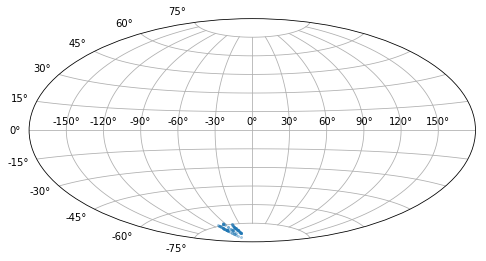

In [9]:
plot_neighbors(example)

## Scikit-Learn Version

First, we have to work with pure array, so we'll save the coordinates as an array of tuples.

In [37]:
radec = []
for f in files:
    cra = Angle(f[0:2]+'h'+f[2:4]+'m'+f[4:6]+'s')
    cdec = Angle(f[6:9]+'d'+f[9:11]+'m')
    radec.append([cra.arcsecond, cdec.arcsecond])

Scikit Learn consideres the self star as it's most nearest neighbor, so if we want to perform an all-in-all analysis, we'll have to declare n_neighbots=n+1, where n is the total quantity of stars.

In [38]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=4310, algorithm='auto', metric='euclidean').fit(radec)
distances, indices = nbrs.kneighbors(radec)

Indexes of neirest neighbors sorted from minus to mayor distance.

In [39]:
indices

array([[   0,  563, 4191, ...,  191, 2391, 3920],
       [   1, 1055,  277, ...,  191, 2391, 3920],
       [1569,    2, 2558, ..., 3705, 2391, 3920],
       ...,
       [4307, 3420, 1185, ..., 3246, 2068, 4038],
       [4308, 2799,  485, ..., 1319,  183, 2070],
       [4309, 3037,  445, ..., 2245, 1343, 3886]])

Function to calculate the n neirest neightbors.

In [13]:
def knn(n):
    nbrs = NearestNeighbors(n_neighbors=4310, algorithm='auto', metric='euclidean').fit(radec)
    _, indices = nbrs.kneighbors(radec)
    return indices

## Execution Times

Repeat the function for different n.

In [59]:
from time import clock
times = []
ne = []

for i in range(0,4310,10):
    ne.append(i)
    start_time = clock()
    knn(i)
    end_time = clock()
    times.append(end_time - start_time)

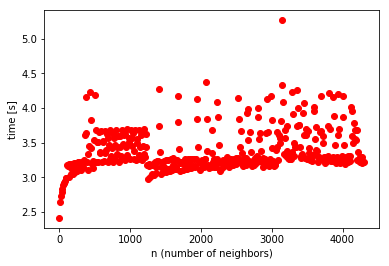

In [60]:
plt.plot(ne, times, 'ro')
plt.xlabel('n (number of neighbors)')
plt.ylabel('time [s]')
plt.show()

In [63]:
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py

z = np.polyfit(ne, times, 2)
f = np.poly1d(z)

other_ne = np.linspace(0, 10000, 50)
other_times = f(other_ne)

trace1 = go.Scatter(
    x=ne,
    y=times,
    mode='markers',
    name='Data',
    marker=dict(
        size=12
    )
)

trace2 = go.Scatter(
    x=other_ne,
    y=other_times,
    mode='lines',
    name='Fit'
)

layout = go.Layout(
    title='Polynomial Fit in Python',
)

data = [trace1, trace2]
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='interpolation-and-extrapolation')

To do:
dynamic plot for different star observed (N) and different neighborhood sizes (K).

In [64]:
# Debo tomar las coordenadas de la estrella N (radec[N]) y las coordenadas de las K estrellas vecinas.